In [1]:
#Import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from itertools import product
from tensorflow.python.keras import layers
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import losses
from tensorflow.python.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import backend as K  
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

In [2]:
#Import data files
fullsize_training_inputs = np.load('training_inputs.npy')
fullsize_training_ground_truth = np.load('training_ground_truth.npy')
fullsize_testing_inputs = np.load('testing_inputs.npy')
fullsize_testing_ground_truth = np.load('testing_ground_truth.npy')

In [3]:
#Dice the tensor into smaller, square images
def stack_tensor(tensor,num_stack_H,num_stack_W,rotate=False):
    '''
    divides tensor of size (N,H,W,C) into more instances of smaller images (N*n^2,H/n,W/n,C)
    tensor: A four dimensional tensor object or numpy array
    num_stack: number of times to divide width and height
    '''
    #unpack values
    N, H, W, C = tensor.shape
    new_N = N*(num_stack_H*num_stack_W)
    new_H = H//num_stack_H
    new_W = W//num_stack_W
    image_segments = product(range(num_stack_H), range(num_stack_W))
    stacked_tensor = np.empty((new_N,new_H,new_W,C))
    if rotate == True:
        stacked_tensor = np.empty((new_N,new_W,new_H,C))
        tensor = np.swapaxes(tensor,1,2)
        image_segments = product(range(num_stack_W), range(num_stack_H))
        new_H, new_W = new_W, new_H
    new_n=0
    for r, c in image_segments:
        for n in range(N):
            stacked_tensor[new_n,:,:,:] = tensor[n, r*new_H:(r+1)*new_H,c*new_W:(c+1)*new_W,:]
            new_n += 1
    return stacked_tensor

#subtract a mean image to center the data
def preprocess_tensor(tensor):
    '''
    Applies common pre-processing transformations and returns the necessary constants 
    to apply the same transforms to validation and test data
    '''
    tensor_mean = np.mean(tensor,axis=0,keepdims=True)
    preprocessed_tensor = tensor - tensor_mean
    return preprocessed_tensor, tensor_mean

In [4]:
#Apply dicing function and delete fullsize images to save memory
training_inputs = stack_tensor(fullsize_training_inputs,3,4)/255
training_ground_truth = stack_tensor(fullsize_training_ground_truth,3,4)/255
testing_inputs = stack_tensor(fullsize_testing_inputs,3,4)/255
testing_ground_truth = stack_tensor(fullsize_testing_ground_truth,3,4)/255
input_shape = training_inputs.shape

del fullsize_training_inputs
del fullsize_training_ground_truth
del fullsize_testing_inputs
del fullsize_testing_ground_truth

In [5]:
seed = 0
alpha = 10
sigma = 10
global image_seed
image_seed = 0
#Define some additional transormations
def elastic_transform(image):
    #alpha, sigma, random_state must be passed as global variables
    random_state = np.random.RandomState(image_seed)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape[:2])*2 - 1), sigma, mode = "constant",cval = 0)*alpha
    dy = gaussian_filter((random_state.rand(*shape[:2])*2 - 1), sigma, mode = "constant",cval = 0)*alpha
    
    x,y = np.meshgrid(np.arange(int(shape[1])),np.arange(int(shape[0])))
    indices = np.reshape(y+dy,(-1,1)), np.reshape(x+dx,(-1,1))
    
    transformed_image = np.empty(shape)
    for c in range(shape[2]):
        mapped_image = map_coordinates(image[:,:,c],indices, order=1,mode='reflect')
        transformed_image[:,:,c] = mapped_image.reshape((shape[0],shape[1]))
    return transformed_image

def random_noise(image):
    #add random_noise to the images
    #seed must be passed as a global variable
    random_state = np.random.RandomState(image_seed)
    noise_mag = random_state.uniform(low=0.01,high=0.1)
    noise_width = random_state.uniform(low = 0.01, high = 0.5)
    noise = noise_mag*random_state.normal(scale=noise_width,
                                size=image.shape
                            )
    transformed_image = image+noise
    return transformed_image

def additional_image_transformations(image):
    #randomly add noise and a deformation
    image_seed = np.random.choice(10000)
    random_state = np.random.RandomState(image_seed)
    transformed_image = image
    alpha = random_state.uniform(low=50,high=250)
    sigma = random_state.uniform(low=10,high=20)
    if random_state.choice(2) == 1:
        transformed_image = random_noise(transformed_image)
    if random_state.choice(2) == 1:
        transformed_image = elastic_transform(transformed_image)
    return transformed_image

def additional_mask_transformations(image):
    #randomly add a deformation
    random_state = np.random.RandomState(image_seed)
    transformed_image = image
    alpha = random_state.uniform(low=50,high=250)
    sigma = random_state.uniform(low=10,high=20)
    if random_state.choice(2) == 1:
        pass
    if random_state.choice(2) == 1:
        transformed_image = elastic_transform(image)
    return transformed_image

In [6]:
# we create two instances with the same arguments
mask_gen_args = {'rotation_range':90,
                 'width_shift_range':0.05,
                 'height_shift_range':0.05,
                 'zoom_range':0.05,
                 'fill_mode':'constant',
                 'cval':0,
                 'horizontal_flip':True,
                 'vertical_flip':True,
                 'preprocessing_function':additional_mask_transformations
                }

image_gen_args = mask_gen_args.copy()
#image_gen_args['preprocessing_function'] = additional_image_transformations

In [7]:
def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(filters=num_filters,kernel_size=(3, 3),padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(filters=num_filters,kernel_size=(3, 3),padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(filters=num_filters,kernel_size=(2, 2),strides=(2, 2),padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(filters=num_filters,kernel_size=(3, 3),padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(filters=num_filters,kernel_size=(3, 3),padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)

    return decoder

In [8]:
inputs = layers.Input(shape = training_inputs.shape[1:])
# 256

encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
# 16

encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512)
# 8

center = conv_block(encoder4_pool, 1024)
# center

decoder4 = decoder_block(center, encoder4, 512)
# 16

decoder3 = decoder_block(decoder4, encoder3, 256)
# 32

decoder2 = decoder_block(decoder3, encoder2, 128)
# 64

decoder1 = decoder_block(decoder2, encoder1, 64)
# 128

decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

W1106 10:16:40.530465  7768 deprecation.py:506] From C:\Users\Malec\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
model = models.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

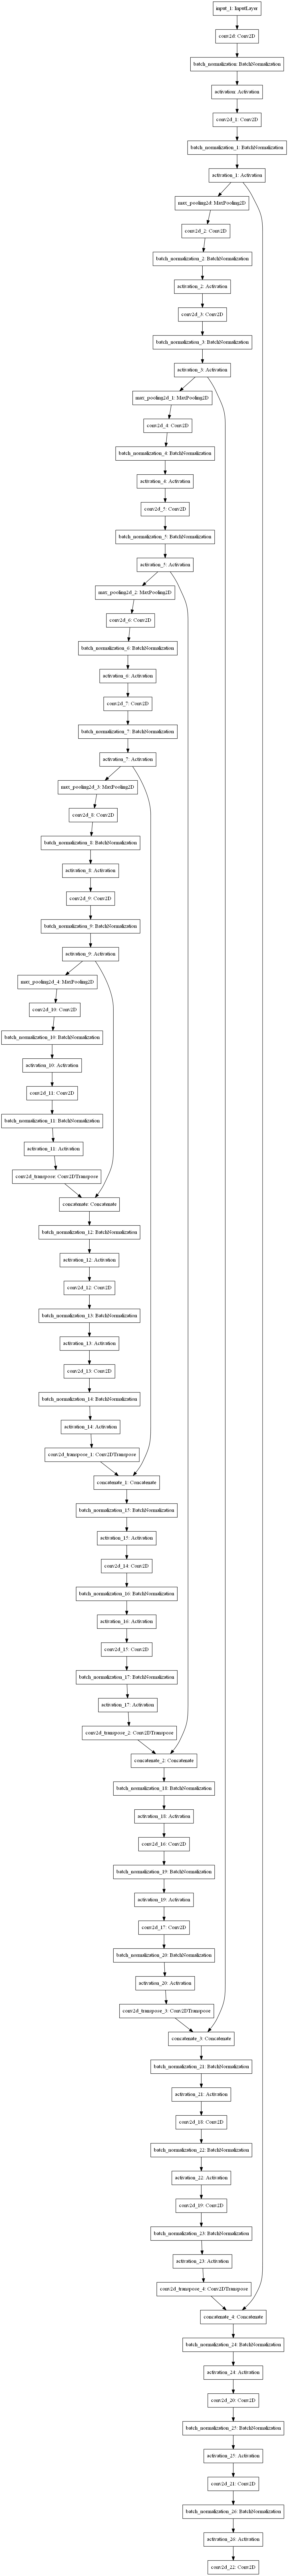

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(model,to_file = 'model_plot.png',rankdir='TB')

In [11]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def log_dice_loss(y_true, y_pred):
    loss = tf.log(1 - dice_coeff(y_true, y_pred))
    return loss

def bce_loss(y_true,y_pred):
    bce_loss = losses.binary_crossentropy(y_true,y_pred)
    return bce_loss

In [12]:
nonzero_inds = []
for i in range(training_ground_truth.shape[0]):
    if training_ground_truth[i,:].sum() != 0:
        nonzero_inds.append(i)
cleaned_inputs = training_inputs[nonzero_inds,:,:,:]
cleaned_ground_truth = training_ground_truth[nonzero_inds,:,:,:]

In [13]:
cleaned_inputs, train_mean = preprocess_tensor(cleaned_inputs)

In [14]:
val_inds = np.random.choice(testing_inputs.shape[0],100)
validation_inputs = testing_inputs[val_inds,:]
validation_ground_truth = testing_ground_truth[val_inds,:]
validation_inputs -= train_mean

In [19]:
batch_size = 11
seed = 153
#Instantiate Data Generators
image_datagen = ImageDataGenerator(**image_gen_args)
mask_datagen = ImageDataGenerator(**mask_gen_args)

train_image_generator = image_datagen.flow(
    cleaned_inputs,
    batch_size=batch_size,
    seed=seed)

train_mask_generator = mask_datagen.flow(
    cleaned_ground_truth,
    batch_size=batch_size,
    seed=seed)

train_generator = (pair for pair in zip(train_image_generator,train_mask_generator))

In [22]:
#Initiate Adam optimizer with default values
opt = optimizers.Adam(lr = 1e-6)

#Compile model
model.compile(optimizer=opt, 
              loss=log_dice_loss, 
              metrics=[dice_coeff])

#Some parameters

epochs = 10

#Define a model callback
save_model_path = 'tmp/weights_031.hdf5'
cp = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, 
                                        monitor='val_loss',
                                        save_best_only=True, 
                                        verbose=1
                                       )
#001: only noise and elastic deformations, 7x7 effective filter, batch norm
#002: small zoom, 5x5 effective filter, batch norm
#003: 5x5effective filter, divided training examples, batch norm, pre-processing
#004: 5x5 effective filter, divided training examples, batch norm, subtract mean, batch_size 5
#005: 5x5 effective filter, divided training examples, batch norm, subtract mean, batch_size 11
#006: Same as 005, but a faster learning rate
#007: Same as 005, but a slower learning rate
#008: Same as 007, but the bce+dice loss
#009: Same as 008, but 7x7 effective filter
#010: Same as 009, but 3x3 effective filter
#011: Same as 007, but one extra 16 filter layer
#012: Same as 007, but center layer is only 512 filters
#013: Same as 005, but one more convolution in decoder
#013: Same as 005, but two epochs
#014: Same as 005, but two epochs, bce_dice
#015: Same as 014, dataaugmentation
#016: Same as 015, dataaugmentation, val and train generators
#017: Same as 016, batch_size 11, 5 epochs, Adam()
#018: 256x256 images, batch_size 11, 5 epochs, Adam(eps=0.1)
#019: 256x256 images, batch_size 11, augmentation, 5 epochs, Adam() Test 0.81 Train 0.79
#020: 019 but learning_rate 1e-6, took rotation off the augmentor Test .90 Train .89
#021: 020 but lr1e-7 Train 0.11 Test 0.12
#022: 020 but 1e-6 eps 0.1 10 epochs Train 0.11 Test 0.09
#023: 020 but 1e-5 10 epochs Train 0.47 Test 0.42
#024: 023 removed zero mitochondria examples Train 0.58 Test 0.47
#025: 024 1e-6 bce_dice_loss Train 0.59 Test 0.52
#026: 025 1e-6 dice_loss Train  Test not as good as 20
#027: 1e-9, log_dice_loss, batch_size_11, one extra layer
#028: default, bce loss, batch_size_11, one layer deepeer train 0.90 test 0.86
#029: default, log dice loss, batch_size_8, one layer deeper train 0.93 test 0.86
#030: log dice loss, batch_size_10, one layer deeper train  test 
#031: start with weights for 020, keep training
#032: log dice loss, batch_size 20, lr 1e-5
#033: log dice loss, batch_size 11, 1e-6 no noise augmentation

In [ ]:
#Fit the model
history = model.fit_generator(train_generator,
                              epochs=epochs,
                              steps_per_epoch = cleaned_inputs.shape[0]//batch_size,
                              validation_data=(validation_inputs,validation_ground_truth),
                              shuffle=True,
                              callbacks=[cp],
                              initial_epoch = 0
                             )

Epoch 1/10


In [25]:
#Load best model
model.load_weights(save_model_path)
# Score trained model.
possible_test_inds = [i for i in range(testing_inputs.shape[0]) if i not in val_inds]
test_inds = np.random.choice(possible_test_inds,100,replace=False)
scores = model.evaluate(testing_inputs[test_inds,:,:,:] - train_mean, 
                        testing_ground_truth[test_inds,:,:,:], 
                        verbose=1)

print('Test loss:', scores)

100/100 [==============================] - 19s 188ms/sample - loss: -2.1164 - dice_coeff: 0.8884
Test loss: [-2.1164457607269287, 0.88841707]


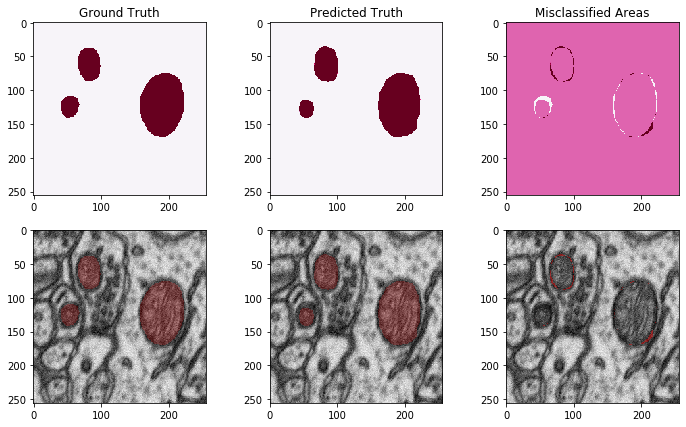

In [37]:
index = 95
_,H,W,_ = testing_inputs.shape
image = testing_inputs[test_inds[index],:,:,0]
predict_mask = np.zeros(shape=(H,W,4))
test_mask = np.zeros(shape=(H,W,4))
oops_mask = np.zeros(shape=(H,W,4))

predict_mask[:,:,0] = model.predict(testing_inputs[test_inds,:,:,:]-train_mean)[index][:,:,0]
predict_mask[:,:,3] = 0.2*(predict_mask[:,:,0]>0.)

test_mask[:,:,0] = testing_ground_truth[test_inds[index],:,:,0]
test_mask[test_mask>1] = 1
test_mask[:,:,3] = 0.2*(test_mask[:,:,0]>0.)


oops_mask[:,:,0] = 0.5*(predict_mask[:,:,0] - test_mask[:,:,0])+0.5
oops_mask[:,:,3] = 0.4*((oops_mask[:,:,0]>0.51))+0.4*(oops_mask[:,:,0]<0.49)

fig = plt.figure(figsize=[12,7])
ax1 = plt.subplot(2,3,1)
ax1.imshow(test_mask[:,:,0],cmap='PuRd')
ax1.set_title('Ground Truth')

ax2 = plt.subplot(2,3,2)
ax2.imshow(predict_mask[:,:,0],cmap='PuRd')
ax2.set_title('Predicted Truth')

ax3 = plt.subplot(2,3,3)
ax3.imshow(oops_mask[:,:,0],cmap='PuRd')
ax3.set_title('Misclassified Areas')

ax4 = plt.subplot(2,3,4)
ax4.imshow(image,cmap = 'gray',label='real_image')
ax4.imshow(test_mask,cmap='Reds')

ax5 = plt.subplot(2,3,5)
ax5.imshow(image,cmap = 'gray',label='predicted_image')
ax5.imshow(predict_mask,cmap='Reds')

ax6 = plt.subplot(2,3,6)
ax6.imshow(image,cmap = 'gray',label='mistakes_image')
ax6.imshow(oops_mask,cmap='PuRd')

plt.show()

In [38]:
def predict_on_fullsize_image(model,image,stride,width=256,train_mean = 0):
    H, W, Ch = image.shape
    R = (H - width)//stride+1
    C = (W - width)//stride+1
    N = R*C
    predict_stack = np.empty(shape=(N,width,width,Ch))
    image_segments = product(range(R), range(C))
    n=0
    for r, c in image_segments:
        predict_stack[n,:,:,:] = image[r*stride:r*stride+width,c*stride:c*stride+width,:]
        n += 1
    
    predictions = model.predict(predict_stack - train_mean)
    combined_predictions = np.zeros(shape = (H,W))
    counts = np.zeros(shape = (H,W))
    
    image_segments = product(range(R), range(C))
    n=0
    for r,c in image_segments:
        combined_predictions[r*stride:r*stride+width,c*stride:c*stride+width] += predictions[n,:,:,0]
        counts[r*stride:r*stride+width,c*stride:c*stride+width] += np.ones(shape = (width,width))
        n += 1
        
    predict_image = combined_predictions / counts
    predict_image[counts == 0] = 0
    return predict_image, counts

In [39]:
fullsize_testing_inputs = np.load('testing_inputs.npy')
fullsize_testing_ground_truth = np.load('testing_ground_truth.npy')

In [40]:
fullsize_ind = 30
predict_image,counts = predict_on_fullsize_image(model,fullsize_testing_inputs[fullsize_ind,:,:,:]/255,32,train_mean=train_mean)

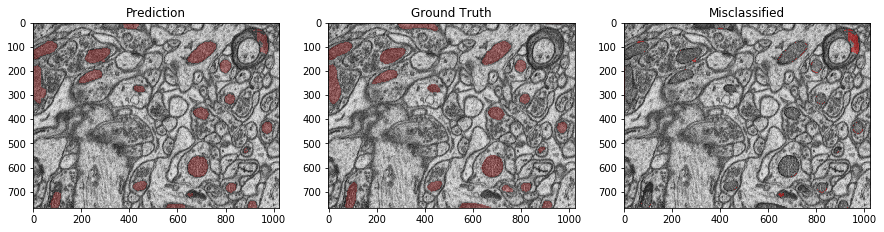

In [41]:
_,H,W,_ = fullsize_testing_inputs.shape
image = fullsize_testing_inputs[fullsize_ind,:,:,0]

predict_mask = np.zeros(shape=(H,W,4))
test_mask = np.zeros(shape=(H,W,4))
oops_mask = np.zeros(shape=(H,W,4))

predict_mask[:,:,0] = predict_image > 0.5
predict_mask[:,:,3] = 0.2*(predict_image>0.)

test_mask[:,:,0] = fullsize_testing_ground_truth[fullsize_ind,:,:,0]/255
test_mask[:,:,3] = 0.2*(test_mask[:,:,0]>0.)


oops_mask[:,:,0] = 0.5*(predict_mask[:,:,0] - test_mask[:,:,0])+0.5
oops_mask[:,:,3] = 0.4*((oops_mask[:,:,0]>0.51))+0.4*(oops_mask[:,:,0]<0.49)

fig = plt.figure(figsize=[15,7])
ax1 = plt.subplot(1,3,1)
ax1.imshow(image,cmap='gray')
ax1.imshow(predict_mask,cmap='PuRd')
ax1.set_title('Prediction')

ax2 = plt.subplot(1,3,2)
ax2.imshow(image,cmap='gray')
ax2.imshow(test_mask,cmap='PuRd')
ax2.set_title('Ground Truth')

ax3 = plt.subplot(1,3,3)
ax3.imshow(image,cmap='gray')
ax3.imshow(oops_mask,cmap='PuRd')
ax3.set_title('Misclassified')

plt.show()